In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
    

In [203]:
def signum(x):
    return np.where(x > 0, 1, -1)

In [204]:
def perceptron(x, w, b):
    return signum(np.dot(w, x) + b)

In [205]:
def normalizeData(data : pd.DataFrame):
    #min-max normalization
    for col in data.columns:
        if data[col].dtype == 'object':
            continue
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

# PreProcessing

# Train Test Split

In [206]:
import warnings
warnings.filterwarnings("ignore")
def splitData(data,class1,class2):
    data = data.sample(frac=1,random_state=45).reset_index(drop=True)
    class1_data = data[data.species == class1]
    class2_data = data[data.species == class2]
    train_data = pd.concat([class1_data[int(len(class1_data)*0.4):],class2_data[int(len(class2_data)*0.4):]])
    test_data = pd.concat([class1_data[:int(len(class1_data)*0.4)],class2_data[:int(len(class2_data)*0.4)]])
    return train_data,test_data

# Model

In [207]:
def train(data,epoch,lr,feature1,feature2,class1,class2,isBias):
    w = np.array([0, 0])
    b = 0
    data=data[[feature1,feature2,"species"]]
    data = data[(data.species == class1) | (data.species == class2)]
    species_dict = {class1:1,class2:-1}
    data.species = data.species.apply(lambda x: species_dict[x])
    for _ in range(epoch):
        for index, row in data.iterrows():
            x = np.array(row)
            y = x[2]
            x = x[0:2]
            if y != perceptron(x, w, b):
                w = w + lr * y * x
                if isBias:
                    b = b + lr * y
    return w,b

In [208]:
def test(data,feature1,feature2,class1,class2,w,b):
    data=data[[feature1,feature2,"species"]]
    species_dict = {class1:1,class2:-1}
    data.species = data.species.replace(species_dict)
    correct = 0
    predictions = []
    actual = []
    for index, row in data.iterrows():
        x = np.array(row)
        y = x[2]
        x = x[0:2]
        predictions.append(perceptron(x, w, b))
        actual.append(y)
        if y == perceptron(x, w, b):
            correct += 1
    return correct/len(data),actual,predictions

# Graphes

In [209]:
def plot_data(y1,y2,x1,x2,w,b,x1label,x2label,cls1,cls2):
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                            np.arange(x2_min, x2_max, 0.02))
    Z = perceptron(np.array([xx1.ravel(), xx2.ravel()]), w.T, b)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4)
    plt.scatter(x1,y1 ,c='red')
    plt.scatter(x2,y2, c='blue')
    plt.xlabel(x1label)
    plt.ylabel(x2label)
    plt.legend(labels = [cls1,cls2],loc='upper left')
    plt.show()

In [210]:
def plot_data_withoutLine(y1,y2,x1,x2,x1label,x2label,cls1,cls2):
    plt.scatter(x1,y1 ,c='red')
    plt.scatter(x2,y2, c='blue')
    plt.xlabel(x1label)
    plt.ylabel(x2label)
    plt.legend(labels = [cls1,cls2],loc='upper left')
    plt.show()

In [211]:
def two_F_graph(data , f1 , f2 , cls1 , cls2 , epochs ,learning_rate,isbias , c_line = True ):
    data1 = data[data["species"] == cls1]
    data2 = data[data["species"] == cls2]
    if c_line==False:
        plot_data_withoutLine(data1[f1] ,data1[f2] , data2[f1] ,data2[f2] ,f1 , f2,cls1,cls2)
    else:
        train_df,test_df = splitData(data,cls1,cls2)
        w,b = train(train_df,epochs,learning_rate,f1,f2,cls1,cls2,isbias)
        acc,actual,predictions = test(test_df,f1,f2,cls1,cls2,w,b)
        print('Accuracy: ',acc)
        print(f1 , f2)
        plot_data(data1[f1] ,data1[f2] , data2[f1] ,data2[f2] ,w , b,f1 , f2,cls1,cls2)  
        return acc,actual,predictions  
        

In [212]:
def graphes(data ,cols, c_line=False):
    for i in range(5):
        j=i+1
        while j<5:
            print("Adelie and Gentoo")
            two_F_graph(data , cols[i] , cols[j] , "Adelie" , "Gentoo" , c_line = c_line )
            print("Adelie and Chinstrap")
            two_F_graph(data , cols[i] , cols[j] , "Adelie" , "Chinstrap" , c_line = c_line )
            print("Chinstrap and Gentoo")
            two_F_graph(data , cols[i] , cols[j] , "Chinstrap" , "Gentoo" , c_line = c_line )
            j=j+1

In [213]:
def confusion_matrix(actual,predictions):
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    for actual_value, predicted_value in zip(actual,predictions):
        if predicted_value == actual_value: # t?
            if predicted_value == 1: # tp
                tp += 1
            else: # tn
                tn += 1
        else: # f?
            if predicted_value == 1: # fp
                fp += 1
            else: # fn
                fn += 1
                
    cm = [[tn, fp],[fn, tp]]
    return cm

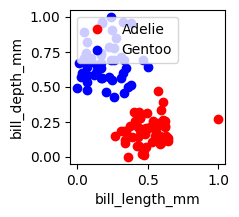

Accuracy:  0.975
bill_length_mm bill_depth_mm


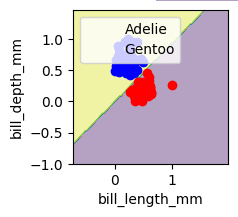

[[TN, FP],[FN, TP]]
[[19, 1], [0, 20]]


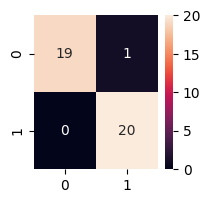

<Figure size 500x500 with 0 Axes>

In [214]:
if __name__ == "__main__":
    data = pd.read_csv("penguins.csv")
    data=normalizeData(data)
    data.gender.fillna(data.gender.describe().top,inplace=True)
    data.gender.replace({"male":1,"female":0},inplace=True)
    cols=data.columns.to_list()
    cols.remove("species")
    
    
    #graphes(data , c_line=True , cols=cols)
    
    
    two_F_graph(data,'bill_length_mm','bill_depth_mm','Adelie','Gentoo',1000,1,True,c_line=False)
    acc,actual,predictions = two_F_graph(data,'bill_length_mm','bill_depth_mm','Adelie','Gentoo',1000,1,True,c_line=True)
    cm = confusion_matrix(actual,predictions)
    print("[[TN, FP],[FN, TP]]")
    print(cm) 
    sns.heatmap(cm, annot=True)  
    
    